# Transfer learning and fine-tuning

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch.

**Goals** In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.
In this case, you do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

**Workflow**: You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, which loads images and applies data augmentations
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import datasets, transforms, models

## Data

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a dataset using `torchvision.datasets.ImageFolder` for training and validation. You can learn more about loading data in PyTorch by reading the ImageFolder [documentation](https://pytorch.org/vision/0.15/generated/torchvision.datasets.ImageFolder.html) and this [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [9]:
import requests
import zipfile
import io

def download_and_extract_zip(url, extract_to='.'):
    # Download the zip file
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise exception if invalid response

    # Extract the zip file
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(extract_to)

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
download_and_extract_zip(_URL, extract_to='.')

def subsample_db(db, n=200):
    idx = np.random.permutation(len(db))[:n]
    db.samples = [db.samples[i] for i in idx]
    db.targets = [db.targets[i] for i in idx]
    return db


db_train = datasets.ImageFolder(root='cats_and_dogs_filtered', transform=None)
db_train = subsample_db(db_train, n=300)
print(db_train)
db_test = datasets.ImageFolder(root='cats_and_dogs_filtered', transform=None)
db_test = subsample_db(db_test, n=200)
print(db_test)

Dataset ImageFolder
    Number of datapoints: 300
    Root location: cats_and_dogs_filtered
Dataset ImageFolder
    Number of datapoints: 200
    Root location: cats_and_dogs_filtered


Show some images and labels from the training set:

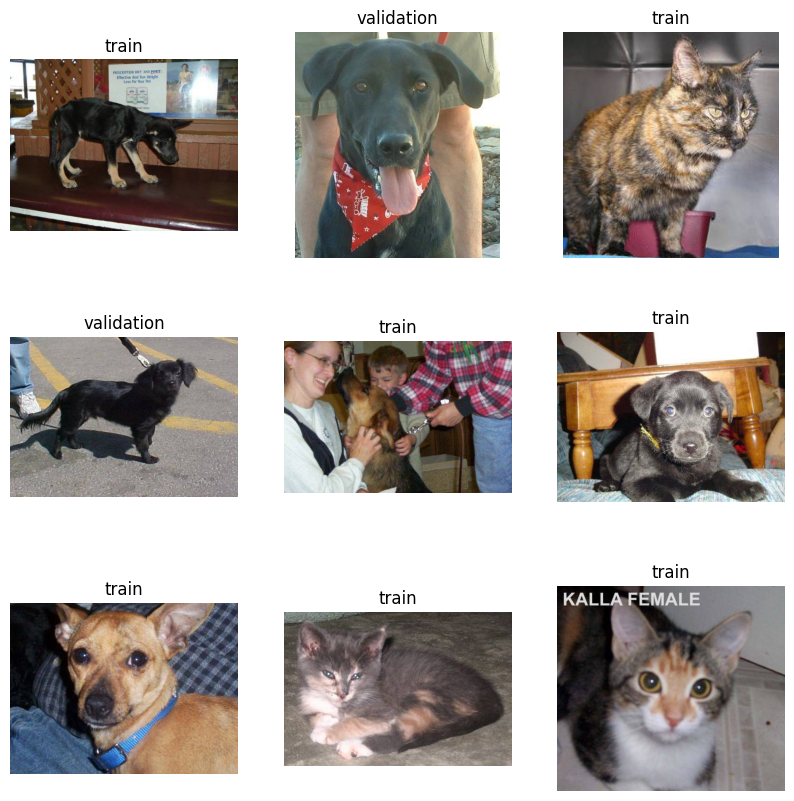

In [10]:
import random
class_names = db_train.classes

plt.figure(figsize=(10, 10))
for i in range(9):
    idx = random.randint(0, len(db_train)-1)
    img, label = db_train[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis("off")

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [11]:
db_train.transform = transforms.Compose([
    transforms.RandomResizedCrop(size=[224,224], scale=(0.5,1.)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(             # Normalize using ImageNet's mean and standard deviation
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
db_test.transform = transforms.Compose([
    transforms.Resize(256),           # Resize the short side of the image to 256
    transforms.CenterCrop(224),       # Crop a center patch of the image of size 224x224
    transforms.ToTensor(),            # Convert the image to tensor format
    transforms.Normalize(             # Normalize using ImageNet's mean and standard deviation
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

### Training utils
First, we define all functions that we'll be using for training and testing our models.
This part of the code is often the same for most neural net training pipelines.

In [12]:
from torch.utils.data import DataLoader
from torch import nn
import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def fit_one_epoch(model, opt, loader):
    model.train(True)
    loss = nn.CrossEntropyLoss()
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        l = loss(pred, labels)
        acc = (pred.argmax(1) == labels).float().mean()

        l.backward()
        opt.step()
        opt.zero_grad()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)

@torch.no_grad()
def eval(model, loader):
    model.train(False)
    loss = nn.CrossEntropyLoss()
    accuracies, losses = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        acc = (pred.argmax(1) == labels).float().mean()
        l = loss(pred, labels)

        accuracies.append(acc.detach().item())
        losses.append(l.detach().item())
    return np.mean(losses), np.mean(accuracies)


def fit(model, loader_train, loader_val, epochs=50, opt=None):
    assert opt is not None
    hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc = [], [], [], []
    for epoch in range(epochs):
        val_l, val_acc = eval(model, loader_val)
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)

        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}  Val Loss = {val_l:.3f}   Train Acc = {tr_acc:.3f}   Val Acc = {val_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_val_loss.append(val_l)
        hist_tr_acc.append(tr_acc)
        hist_val_acc.append(val_acc)
    return hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc

def plot_training_history(hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc):
    plt.subplot(1, 2, 1)
    plt.plot(hist_tr_acc, label='train accuracy')
    plt.plot(hist_val_acc, label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(hist_tr_loss, label='train loss')
    plt.plot(hist_val_loss, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

## Training from scratch
First, we will try (and fail) to train a deep learning model from scratch.

To do this, we first need to create the model and analyze it's structure. Let's use the **AlexNet** model.

In [13]:
# Create the base model from the pre-trained model AlexNet
model = models.alexnet()
model = model.to(device)
print(model)

image_batch, label_batch = db_train[0]
feature_batch = model(image_batch[None].to(device))
print('Output shape:', feature_batch.shape)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

As you can see, the AlexNet model was initialy designed to predict 1000 classes. Note that, in the structure above, the last layer of the model (`Linear(in_features=4096, out_features=1000, bias=True)`) has 1000 outputs.
To generate predictions for our dogs vs cats classification problem, we need to replace this output layer with a new Linear layer with only 2 outputs. We can achieve this by running:

```python
model.classifier[6] = torch.nn.Linear(4096, 2)
```

So, lets now use the utility functions defined above to trained the model.


In [14]:
epochs = 5
lr = 0.01

# Define the data loaders
loader_train = DataLoader(db_train, batch_size=25, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=25, shuffle=False)

# Define the model (AlexNet)
model = models.alexnet()
model.classifier[6] = torch.nn.Linear(4096, 2)
model = model.to(device)

# Define the optimizer
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

# Fit the model to our data
hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

100%|██████████| 12/12 [00:08<00:00,  1.44it/s]

Finished epoch 0 of 5: Train Loss = 0.683  Val Loss = 0.699   Train Acc = 0.583   Val Acc = 0.280



100%|██████████| 12/12 [00:08<00:00,  1.47it/s]

Finished epoch 1 of 5: Train Loss = 0.644  Val Loss = 0.639   Train Acc = 0.667   Val Acc = 0.720



100%|██████████| 12/12 [00:09<00:00,  1.32it/s]

Finished epoch 2 of 5: Train Loss = 0.642  Val Loss = 0.597   Train Acc = 0.667   Val Acc = 0.720



100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

Finished epoch 3 of 5: Train Loss = 0.638  Val Loss = 0.601   Train Acc = 0.667   Val Acc = 0.720



100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

Finished epoch 4 of 5: Train Loss = 0.639  Val Loss = 0.610   Train Acc = 0.667   Val Acc = 0.720


#### Learning curves

Let's take a look at the learning curves of the training and test accuracy/loss when training the AlexNet model from scratch.

100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


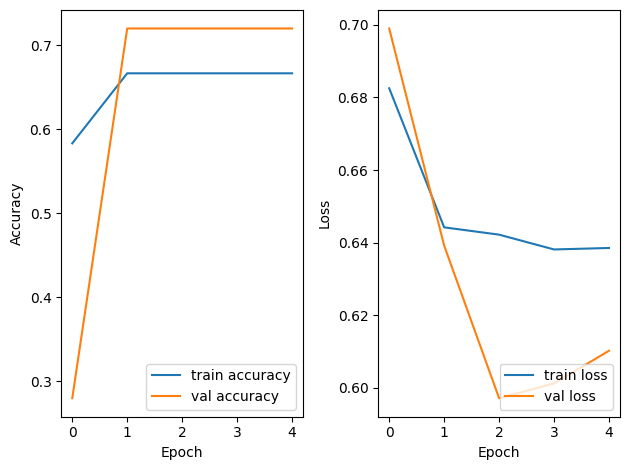

Test accuracy: 72.00%
Test loss: 0.605


In [15]:
l, acc = eval(model, loader_test)
plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
print(f'Test accuracy: {acc*100:.2f}%')
print(f'Test loss: {l:.3f}')

As we can see we didn't make much progress. Both the training and test accuracy is still close to 50%. Since our dataset only has 2 classes, 50% is the accuracy of a classifier that outputs completely random predictions.

## Transfer Learning
In practice, it is rare to train a large network (such as AlexNet) from scratch.
This is because to be effective, large models need to be trained on large datasets, which requires large computational resources.
Instead of training a network from scratch, we can use a network that has already been trained on large datasets and tune it for the task at hand. This process of adapting the weights of a model trained for another task is known as transfer learning.
Two transfer learning strategies are commonly used: **Feature extraction** or **Finetuning**

## Feature extraction
In this strategy, we do not update the original model (its weights stay "frozen"). We simply use the model to extract features, and learn a classifier on top of these features.

To accomplish this, we need to first instantiate the model using the pretrained weights as the initialization. In PyTorch, this can be accomplished by using the flag `weights=models.AlexNet_Weights.DEFAULT`. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. Then, we freeze all the parameters of the model, by setting `p.requires_grad = False`. Finally, we replace the output layer with a Linear classifier for 2 classes.

```python
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
for p in model.parameters():
    p.requires_grad = False
model.classifier[6] = torch.nn.Linear(4096, 2)
```

Let's rerun the model with this new training strategy.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 12/12 [00:03<00:00,  3.41it/s]

Finished epoch 0 of 10: Train Loss = 1.883  Val Loss = 0.786   Train Acc = 0.573   Val Acc = 0.480



100%|██████████| 12/12 [00:03<00:00,  3.18it/s]

Finished epoch 1 of 10: Train Loss = 2.340  Val Loss = 2.596   Train Acc = 0.690   Val Acc = 0.600



100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

Finished epoch 2 of 10: Train Loss = 2.969  Val Loss = 3.559   Train Acc = 0.697   Val Acc = 0.640



100%|██████████| 12/12 [00:03<00:00,  3.32it/s]

Finished epoch 3 of 10: Train Loss = 2.534  Val Loss = 4.979   Train Acc = 0.723   Val Acc = 0.615



100%|██████████| 12/12 [00:03<00:00,  3.20it/s]

Finished epoch 4 of 10: Train Loss = 1.547  Val Loss = 6.033   Train Acc = 0.813   Val Acc = 0.545



100%|██████████| 12/12 [00:03<00:00,  3.50it/s]

Finished epoch 5 of 10: Train Loss = 1.897  Val Loss = 5.291   Train Acc = 0.823   Val Acc = 0.635



100%|██████████| 12/12 [00:03<00:00,  3.10it/s]

Finished epoch 6 of 10: Train Loss = 2.498  Val Loss = 6.207   Train Acc = 0.757   Val Acc = 0.545



100%|██████████| 12/12 [00:03<00:00,  3.34it/s]

Finished epoch 7 of 10: Train Loss = 3.292  Val Loss = 5.624   Train Acc = 0.797   Val Acc = 0.590



100%|██████████| 12/12 [00:03<00:00,  3.31it/s]

Finished epoch 8 of 10: Train Loss = 2.843  Val Loss = 7.329   Train Acc = 0.813   Val Acc = 0.555



100%|██████████| 12/12 [00:03<00:00,  3.26it/s]

Finished epoch 9 of 10: Train Loss = 2.723  Val Loss = 10.929   Train Acc = 0.797   Val Acc = 0.460



100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


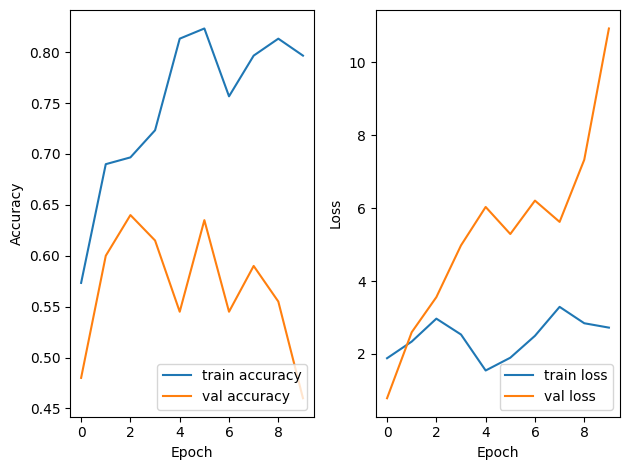

Test accuracy: 50.78%
Test loss: 10.229


In [16]:
epochs = 10
lr = 0.01

loader_train = DataLoader(db_train, batch_size=25, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=25, shuffle=False)

# Define the model
model = models.alexnet(pretrained=True)
for p in model.parameters():
    p.requires_grad = False
model.classifier[6] = torch.nn.Linear(4096, 2)
model = model.to(device)

opt = torch.optim.SGD(model.classifier[6].parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

# Training
hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

# Testing
loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
l, acc = eval(model, loader_test)
plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
print(f'Test accuracy: {acc*100:.2f}%')
print(f'Test loss: {l:.3f}')

## Finetuning
With the previous strategy, only the classifier was learned. One way to increase performance even further is to train (or "fine-tune") the weights of the pre-trained model together with the weights of the classifier. The training process will force the weights to be tuned from generic features to features optimized specifically to the dataset. Also, it is often beneficial to only finetune the weights from a small number of top layers and keep the bottom layers frozen. This is because the first few layers learn very simple and generic features that generalize to almost all types of images. Only the higher layers specialize on the dataset at hand.

Note: Because the majority of the model has already been trained, it is important to keep the learning rate small. If the learning rate is too high, then the model weights will change "too much" from the pre-trained weights, and the knowledge learned from the large pre-training dataset will be lost.

100%|██████████| 12/12 [00:05<00:00,  2.33it/s]

Finished epoch 0 of 2: Train Loss = 2.154  Val Loss = 10.229   Train Acc = 0.827   Val Acc = 0.508



100%|██████████| 12/12 [00:05<00:00,  2.35it/s]

Finished epoch 1 of 2: Train Loss = 3.038  Val Loss = 5.097   Train Acc = 0.823   Val Acc = 0.637



100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


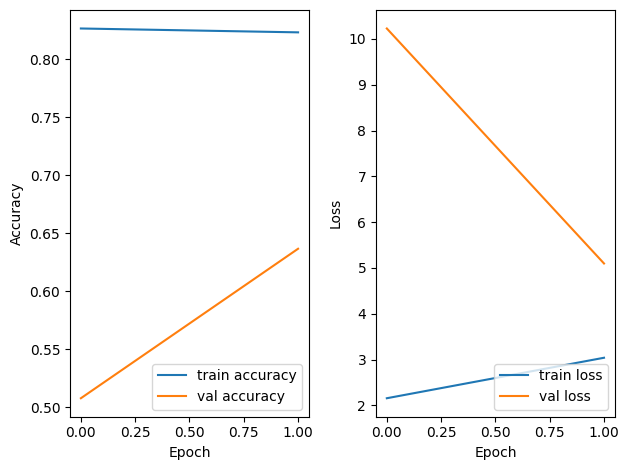

Test accuracy: 68.36%
Test loss: 5.416


In [17]:
epochs = 2
lr = 0.001

# Change the model
for p in model.classifier.parameters():
    p.requires_grad = True

# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
opt = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)

# Training
hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

# Testing
loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
l, acc = eval(model, loader_test)
plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
print(f'Test accuracy: {acc*100:.2f}%')
print(f'Test loss: {l:.3f}')

### Model's predictions
Finally, it is always good practice to visualize the model predictions.

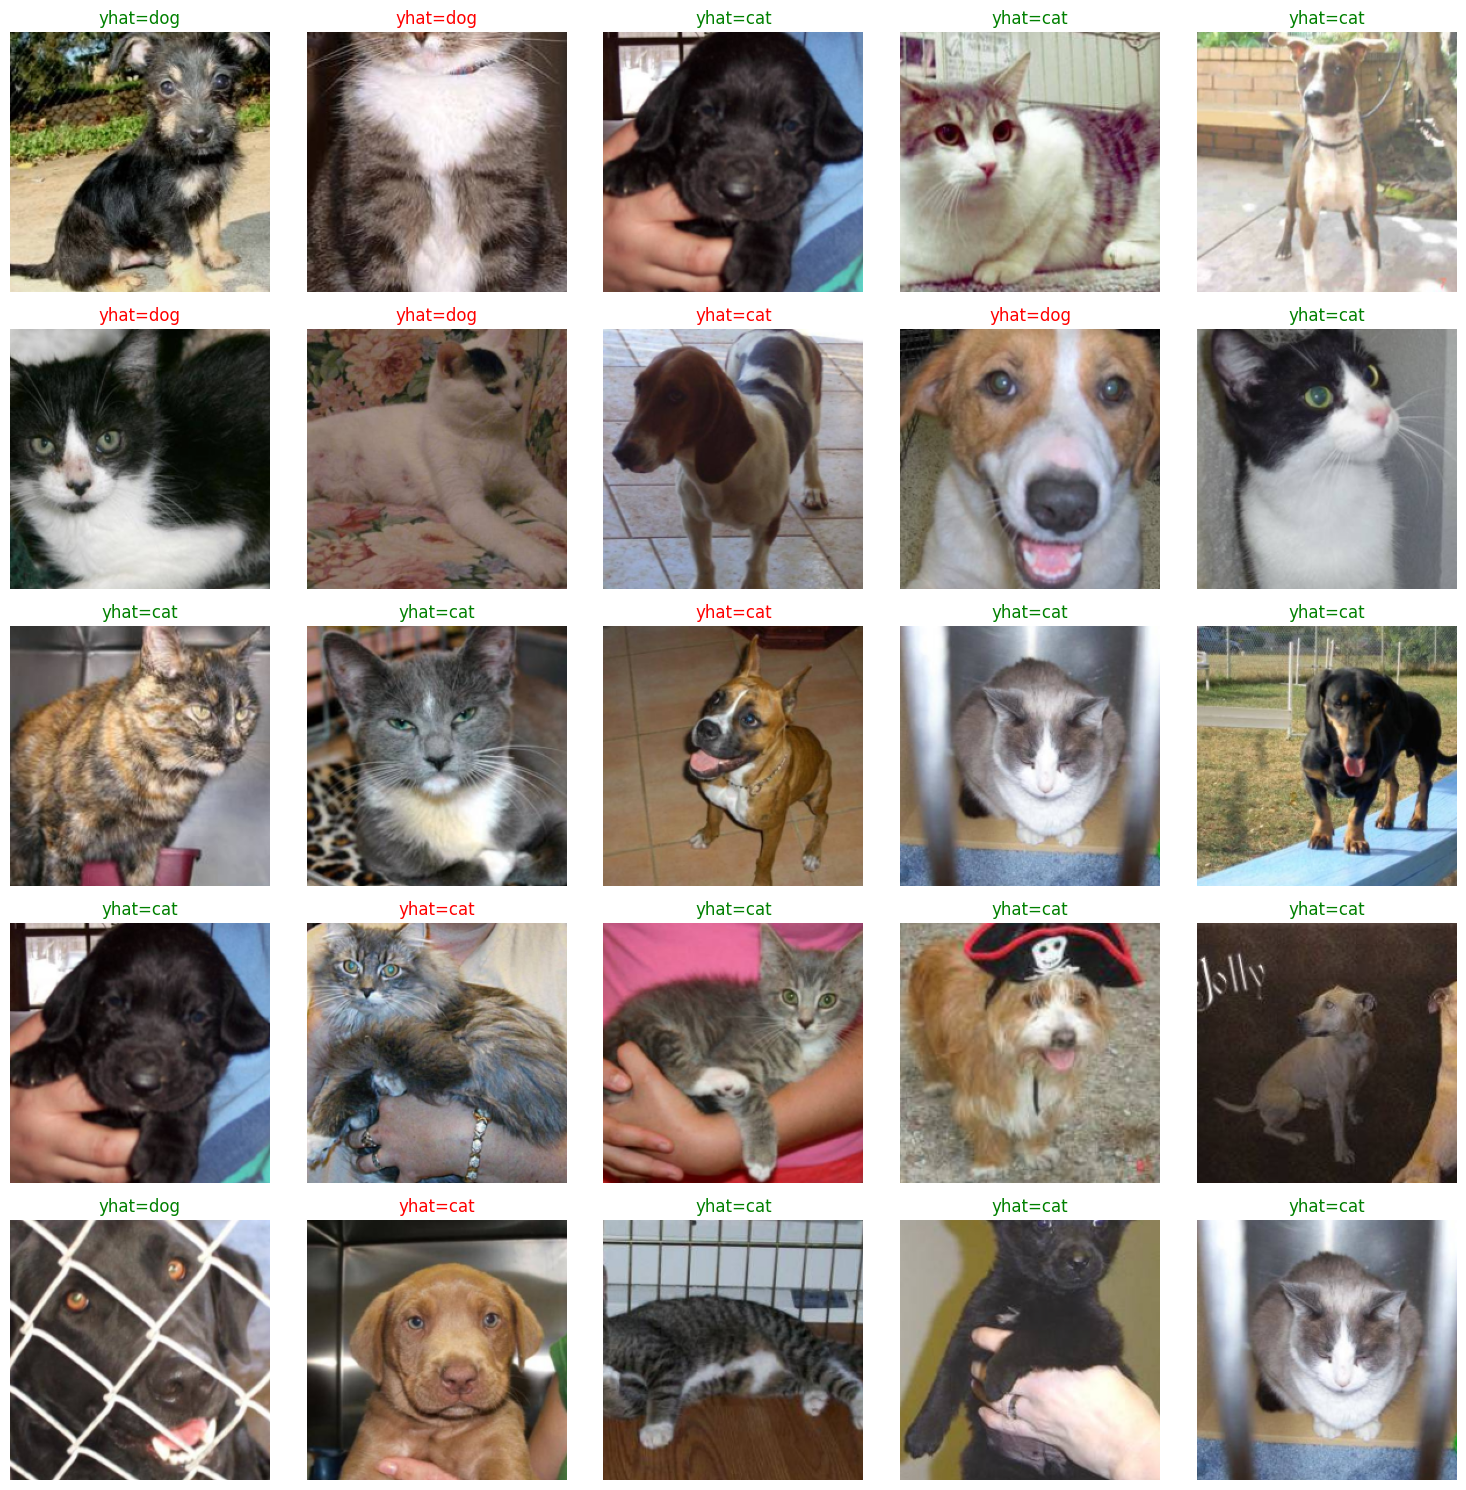

In [18]:
def undo_normalization(img):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    img = img * std + mean
    img = img.permute([1, 2, 0]).numpy()
    return img
model = model.cpu()
label_names = {0: 'cat', 1: 'dog'}
plt.figure(figsize=(3*5,3*5))
for i in range(25):
    img, label = db_test[random.randint(0, len(db_test)-1)]
    with torch.no_grad():
        pred = model(img[None])[0]
        pred = pred.argmax().item()

    plt.subplot(5, 5, 1+i)
    plt.imshow(undo_normalization(img))
    plt.title(f"yhat={label_names[pred]}", color="g" if label == pred else "r")
    plt.axis(False)
plt.tight_layout()
